In [1]:
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import myfm
from myfm import RelationBlock
from scipy import sparse as sps

from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

def load_cil(dataset="split"):

    file = "data_train" if dataset != "test" else "sampleSubmission"
    data = pd.read_csv(f'../data/{file}.csv', index_col=0)
    data['user'] = data.index.str.split('_').str[0].str[1:].astype('int32')
    data['movie'] = data.index.str.split('_').str[1].str[1:].astype('int32')
    data.rename(columns={'Prediction': 'rating'}, inplace=True)
    data['rating'] = data['rating'].astype('uint8')
    data = data[['user', 'movie', 'rating']]

    data['user'] = data['user']
    data['movie'] = data['movie']
    # print("Subtracted {} from user and movie".format(1))

    user_num = 10000  # int(data['user'].max() + 1)
    movie_num = 1000  # int(data['movie'].max() + 1)
    print("User num: {}, Movie num: {}".format(user_num, movie_num))

    train_data = val_data = None
    if dataset == "test":
        val_data = data
    elif dataset == "train":
        train_data = data
    else:
        train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    return train_data, val_data, user_num, movie_num

In [2]:
train_data, val_data, user_num, movie_num = load_cil("split")

User num: 10000, Movie num: 1000


In [86]:
_, val_data, user_num, movie_num = load_cil("test")

User num: 10000, Movie num: 1000


In [3]:
# index "0" is reserved for unknown ids.
user_to_index = defaultdict(lambda : 0, { uid: i+1 for i,uid in enumerate(np.unique(train_data.user)) })
movie_to_index = defaultdict(lambda: 0, { mid: i+1 for i,mid in enumerate(np.unique(train_data.movie))})
USER_ID_SIZE = len(user_to_index) + 1
MOVIE_ID_SIZE = len(movie_to_index) + 1

In [4]:
# The flags to control the included features.
use_iu = True # use implicit user feature
use_ii = True # use implicit item feature

movie_vs_watched = dict()
user_vs_watched = dict()
for row in train_data.itertuples():
    user_id = row.user
    movie_id = row.movie
    movie_vs_watched.setdefault(movie_id, list()).append(user_id)
    user_vs_watched.setdefault(user_id, list()).append(movie_id)
X_date_train, X_date_test = (None, None)

In [5]:
# given user/movie ids, add additional infos and return it as sparse
def augment_user_id(user_ids):
    Xs = []
    X_uid = sps.lil_matrix((len(user_ids), USER_ID_SIZE))
    for index, user_id in enumerate(user_ids):
        X_uid[index, user_to_index[user_id]] = 1
    Xs.append(X_uid)
    if use_iu:
        X_iu = sps.lil_matrix((len(user_ids), MOVIE_ID_SIZE))
        for index, user_id in enumerate(user_ids):
            watched_movies = user_vs_watched.get(user_id, [])
            normalizer = 1 / max(len(watched_movies), 1) ** 0.5
            for uid in watched_movies:
                X_iu[index, movie_to_index[uid]] = normalizer
        Xs.append(X_iu)
    return sps.hstack(Xs, format='csr')

def augment_movie_id(movie_ids):
    Xs = []
    X_movie = sps.lil_matrix((len(movie_ids), MOVIE_ID_SIZE))
    for index, movie_id in enumerate(movie_ids):
        X_movie[index, movie_to_index[movie_id]] = 1
    Xs.append(X_movie)

    if use_ii:
        X_ii = sps.lil_matrix((len(movie_ids), USER_ID_SIZE))
        for index, movie_id in enumerate(movie_ids):
            watched_users = movie_vs_watched.get(movie_id, [])
            normalizer = 1 / max(len(watched_users), 1) ** 0.5
            for uid in watched_users:
                X_ii[index, user_to_index[uid]] = normalizer
        Xs.append(X_ii)


    return sps.hstack(Xs, format='csr')

In [6]:
train_uid_unique, train_uid_index = np.unique(train_data.user, return_inverse=True)
train_mid_unique, train_mid_index = np.unique(train_data.movie, return_inverse=True)
user_data_train = augment_user_id(train_uid_unique)
movie_data_train = augment_movie_id(train_mid_unique)

test_uid_unique, test_uid_index = np.unique(val_data.user, return_inverse=True)
test_mid_unique, test_mid_index = np.unique(val_data.movie, return_inverse=True)
user_data_test = augment_user_id(test_uid_unique)
movie_data_test = augment_movie_id(test_mid_unique)

In [7]:
block_user_train = RelationBlock(train_uid_index, user_data_train)
block_movie_train = RelationBlock(train_mid_index, movie_data_train)
block_user_test = RelationBlock(test_uid_index, user_data_test)
block_movie_test = RelationBlock(test_mid_index, movie_data_test)

In [8]:
y_train = train_data.rating.values
y_test = val_data.rating.values

In [9]:
FM_RANK = 32
N_ITER = 512
N_KEPT_SAMPLES = 200

In [ ]:
fm_rb = myfm.MyFMRegressor(rank=FM_RANK).fit(
    X_date_train, y_train,
    X_rel=[block_user_train, block_movie_train],
    group_shapes=[USER_ID_SIZE, MOVIE_ID_SIZE, MOVIE_ID_SIZE, USER_ID_SIZE],
    n_iter=N_ITER, n_kept_samples=N_KEPT_SAMPLES
)

alpha = 1.28 w0 = 3.74 :  46%|████▌     | 234/512 [04:35<05:32,  1.19s/it]

In [11]:
test_prediction = fm_rb.predict(
    X_date_test,
    X_rel=[block_user_test, block_movie_test]
)

In [88]:
test_prediction[test_prediction > 5] = 5
test_prediction[test_prediction < 1] = 1
val_data['Prediction'] = test_prediction

In [89]:
rmse = ((y_test - val_data['Prediction']) ** 2).mean() ** 0.5
mae = np.abs(y_test - val_data['Prediction']).mean()
print(f'rmse={rmse}, mae={mae}')

rmse=0.9729213399919445, mae=0.7750139154484639


In [ ]:
# 512, 50 ->  rmse=0.9774482247691249
# 512, 10 -> rmse=0.975...

In [99]:
val_data['Prediction'].to_csv(f"../lightning_logs/BFM/predictions_bfm_plus_plus_grouped.csv")

# Hyperparameter tuning

alpha = 1.11 w0 = 3.74 : 100%|██████████| 512/512 [02:44<00:00,  3.12it/s]


rank=8, rmse=0.9734483070624824, mae=0.7757298442911911


alpha = 1.17 w0 = 3.84 : 100%|██████████| 512/512 [05:09<00:00,  1.65it/s]


rank=16, rmse=0.973754709608048, mae=0.7747024751156685


alpha = 1.29 w0 = 3.79 : 100%|██████████| 512/512 [10:01<00:00,  1.17s/it]


rank=32, rmse=0.9764566695357575, mae=0.7757049962309305


alpha = 1.48 w0 = 3.94 : 100%|██████████| 512/512 [24:31<00:00,  2.87s/it]


rank=64, rmse=0.9788024203444096, mae=0.7759367853828408


alpha = 1.81 w0 = 3.98 : 100%|██████████| 512/512 [39:54<00:00,  4.68s/it]


rank=128, rmse=0.980934189966278, mae=0.7768594137102515


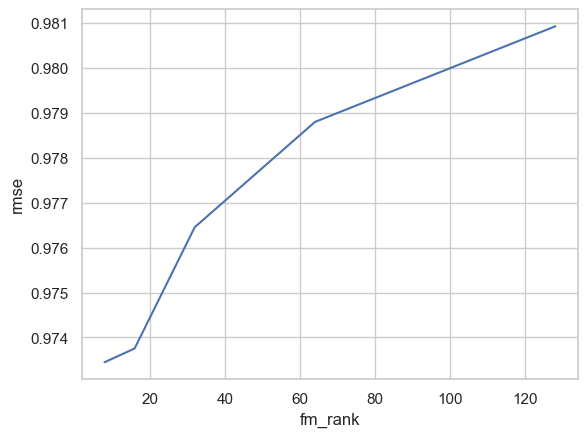

In [14]:
N_ITER = 512
N_KEPT_SAMPLES = 200

fm_rank_list = [8, 16, 32, 64, 128]
rmse_list = []

best_fm_rank = None
best_rmse = 100
best_mae = 100
best_model = None

for FM_RANK in fm_rank_list:
    fm_rb = myfm.MyFMRegressor(rank=FM_RANK).fit(
        X_date_train, y_train,
        X_rel=[block_user_train, block_movie_train],
        group_shapes=[USER_ID_SIZE, MOVIE_ID_SIZE, MOVIE_ID_SIZE, USER_ID_SIZE],
        n_iter=N_ITER, n_kept_samples=N_KEPT_SAMPLES
    )
    test_prediction = fm_rb.predict(
        X_date_test,
        X_rel=[block_user_test, block_movie_test]
    )
    test_prediction[test_prediction > 5] = 5
    test_prediction[test_prediction < 1] = 1
    rmse = ((y_test - test_prediction) ** 2).mean() ** 0.5
    mae = np.abs(y_test - test_prediction).mean()
    print(f'rank={FM_RANK}, rmse={rmse}, mae={mae}')
    rmse_list.append(rmse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_mae = mae
        best_fm_rank = FM_RANK
        best_model = fm_rb
        val_data['Prediction'] = test_prediction
        val_data['Prediction'].to_csv(f"../lightning_logs/BFM/predictions_bfm_plus_plus_grouped_tuned.csv")

# plot rmse vs fm_rank using seaborn
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x=fm_rank_list, y=rmse_list)
ax.set(xlabel='fm_rank', ylabel='rmse')
plt.show()

# Investigate std of predictions

In [78]:
# get all predictions
# w0_samples is of shape (200,)
# w_samples is of shape (200, 22004)
# V_samples is of shape (200, 22004, 10)

# get single prediction
def make_prediction(fm_rb, input):

    w0 = fm_rb.w0_samples
    w1 = np.sum(fm_rb.w_samples * input, axis=1)

    w2 = np.zeros_like(w0)
    nonzero_indices = input.nonzero()[0]
    nonzero_values = input[nonzero_indices]
    v_relevant = fm_rb.V_samples[:,nonzero_indices]
    for p in range(v_relevant.shape[1] - 1):
        for q in range(p+1, v_relevant.shape[1]):
            w2 += np.sum(v_relevant[:,p] * v_relevant[:,q], axis=1) * nonzero_values[p] * nonzero_values[q]

    print(np.mean(w0), np.mean(w1), np.mean(w2))
    print(np.std(w0), np.std(w1), np.std(w2))

    predictions = w0 + w1 + w2

    prediction = np.mean(predictions)
    std = np.std(predictions)
    return prediction, std

In [14]:
val_data['user'][0], val_data['movie'][0], val_data['rating'][0], val_data['Prediction'][0]

(5062, 706, 2, 3.562891538146481)

In [79]:
item = 0

user_data_item = user_data_test[test_uid_index[item]].toarray().reshape(-1)
movie_data_item = movie_data_test[test_mid_index[item]].toarray().reshape(-1)

input = np.concatenate((user_data_item, movie_data_item))

make_prediction(fm_rb, input)

3.6379562430869896 0.019628499410566044 -0.09469320435107241
0.018444414317744042 0.2287670681492365 0.293554303656431


(3.5628915381464834, 0.2389738327713199)